In [1]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs1/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs1/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [3]:
analysis = scripts.Analysis()

In [4]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs1/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band08_wn_1380_1900',
                          'ng_9',
                          'g_ascending_k_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__2__4',
                          'getabsth_auto__auto__auto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_.55_.55_.85__.85_.85__0_.3_.55_.55',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'crd_a140ac7',
                          'atmpro_mls')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [5]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs1/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band08_wn_1380_1900',
                          'ng_9',
                          'g_ascending_k_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__2__4',
                          'getabsth_auto__auto__auto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_.55_.55_.85__.85_.85__0_.3_.55_.55',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'crd_a140ac7',
                          'atmpro_mls')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [6]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [7]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [8]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [9]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [10]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1380

nband = 520

nv = 200

dv = 0.005

tsfc = 294.0

ng = 9

nref = 3

p_refs = (/ 1,  10, 500 /)

t_refs = (/ 250, 250, 250 /)

ng_refs = (/ 3,   2,   4 /)

data wgt
     &     /.55, .55, .85,
     &     .85, .85,
     &     0, .3, .55, .55/

option_wgt_flux = 2

option_wgt_k = 1

option_klin = 0

klin = 6.375563e-24

include 'mls75.pro'


In [11]:
fig.display_hrefanchor()

In [12]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [13]:
table_dgdgs.display_hrefanchor()

In [14]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [15]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [16]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

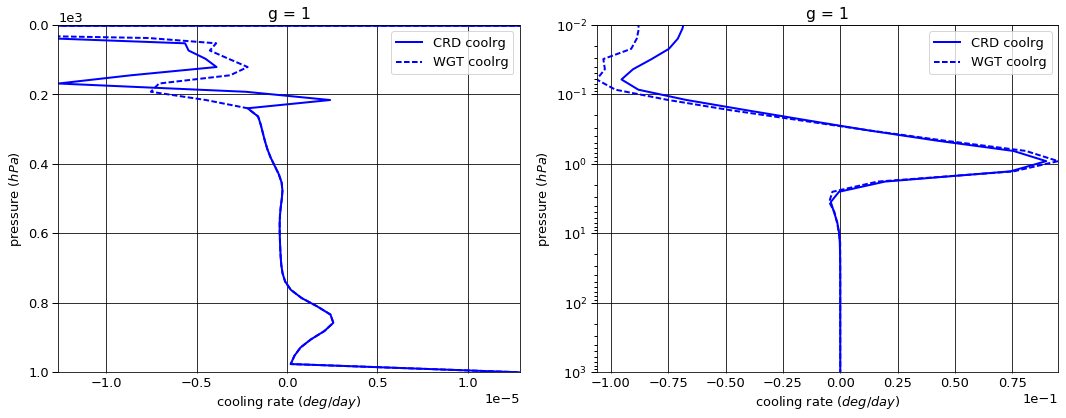

# Figure: cooling rate g-group 2

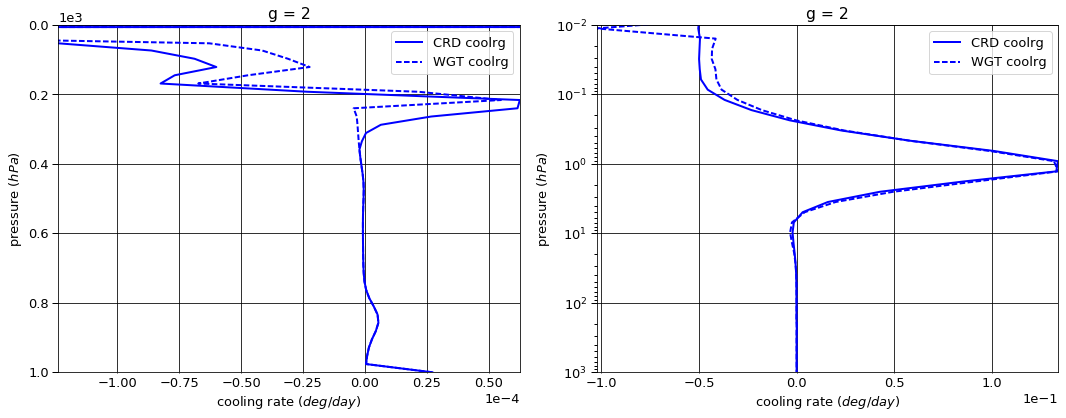

# Figure: cooling rate g-group 3

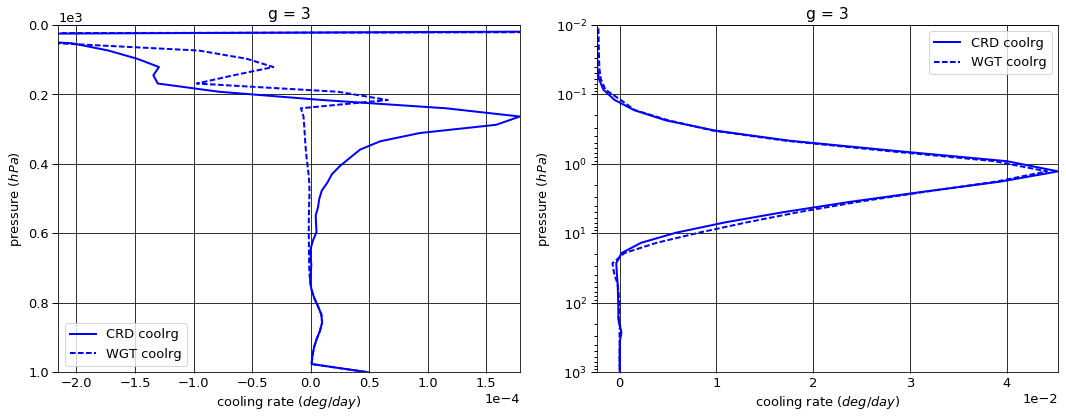

# Figure: cooling rate g-group 4

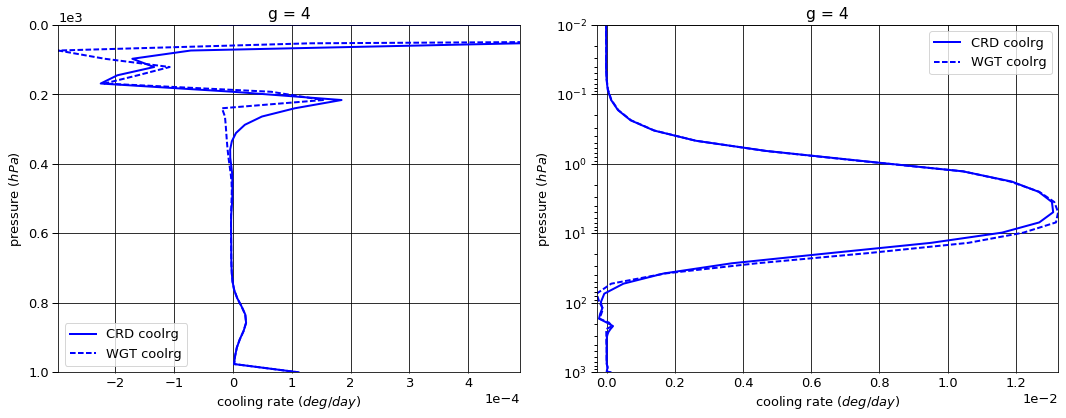

# Figure: cooling rate g-group 5

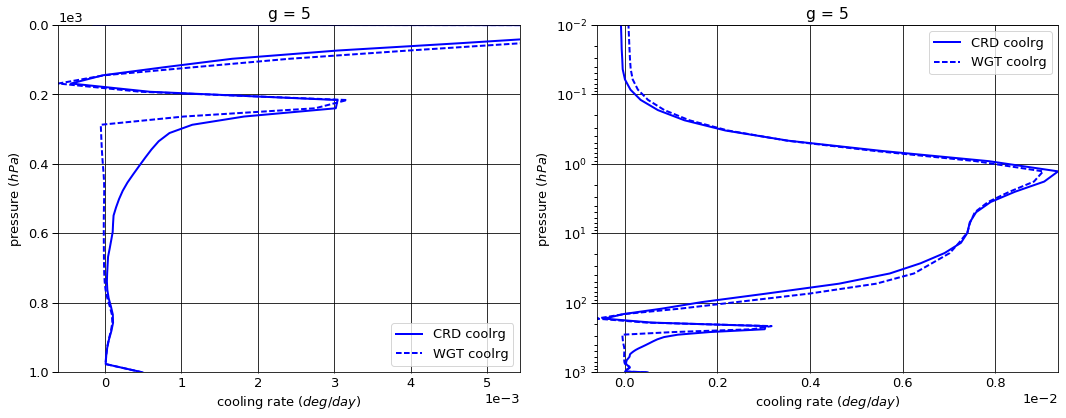

# Figure: cooling rate g-group 6

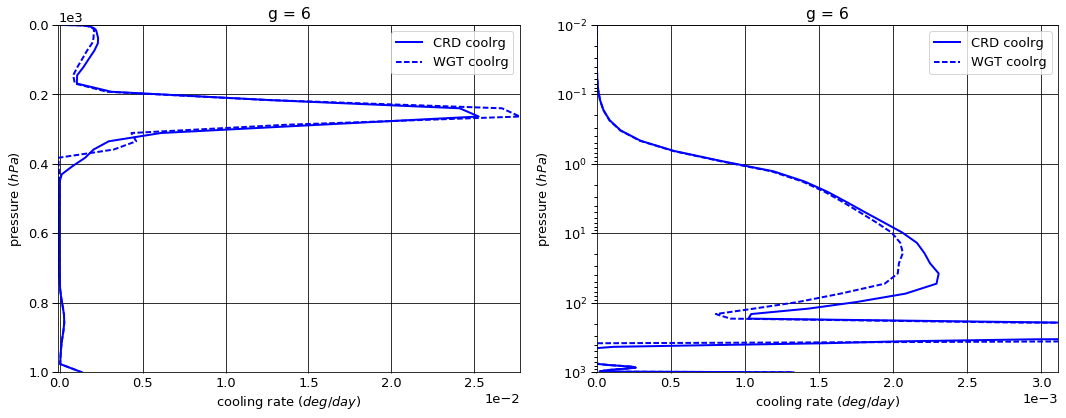

# Figure: cooling rate g-group 7

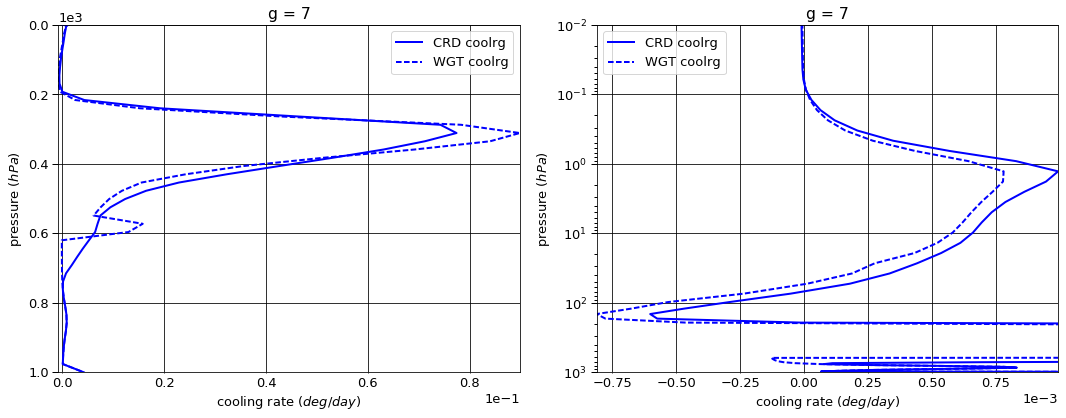

# Figure: cooling rate g-group 8

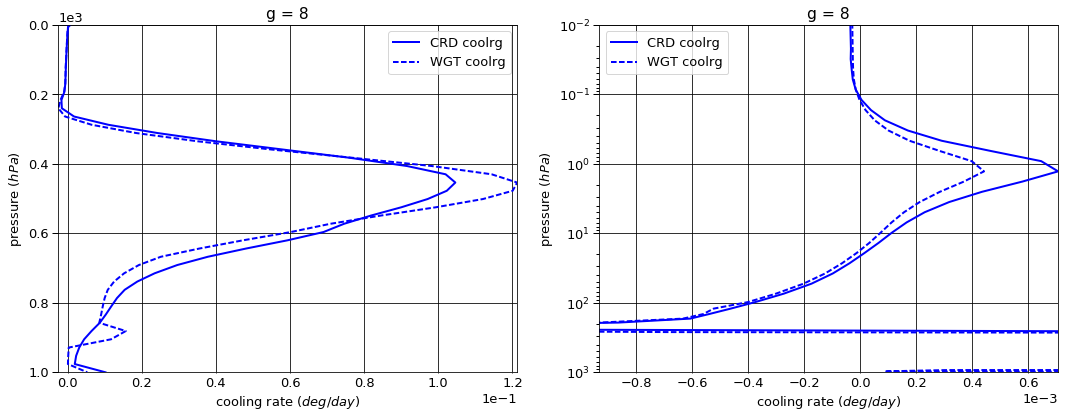

# Figure: cooling rate g-group 9

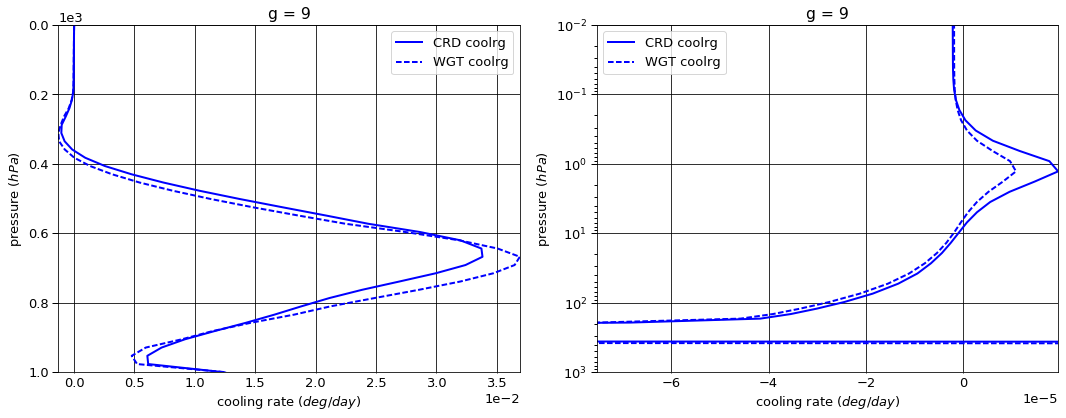

# Figure: cooling rate g-group total

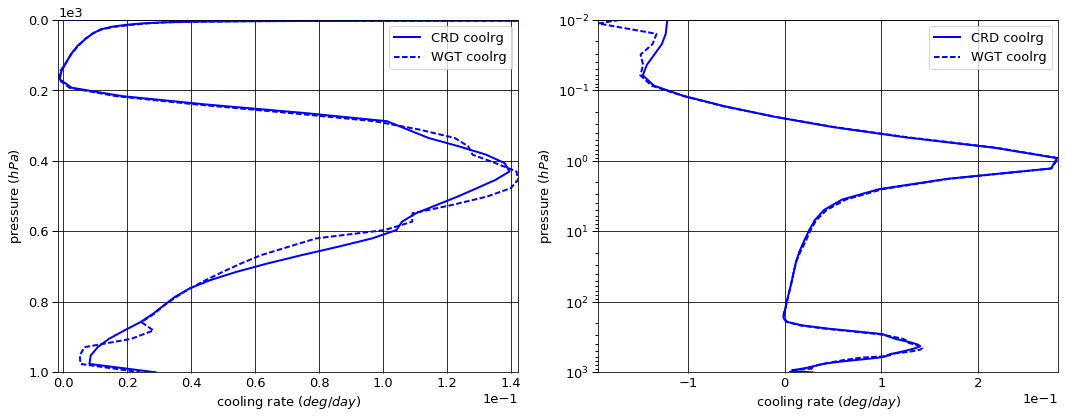

In [17]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [18]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.007582   0.000000 -0.007582
  1013.0   76     -0.031061   0.031025 -0.000036
2 0.0      1      -0.023342   0.000000 -0.023342
  1013.0   76     -0.065712   0.065636 -0.000076
3 0.0      1      -0.023391   0.000000 -0.023391
  1013.0   76     -0.118260   0.118122 -0.000138
4 0.0      1      -0.032797   0.000000 -0.032797
  1013.0   76     -0.269126   0.268814 -0.000312
5 0.0      1      -0.104065   0.000000 -0.104065
  1013.0   76     -1.172203   1.170832 -0.001371
6 0.0      1      -0.311870   0.000000 -0.311870
  1013.0   76     -3.205452   3.201727 -0.003725
7 0.0      1      -1.667543   0.000000 -1.667543
  1013.0   76    -10.096960  10.085203 -0.011758
8 0.0      1      -3.753186   0.000000 -3.753186
  1013.0   76    -12.934457  12.907691 -0.026766
9 0.0      1      -1.351205   0.000000 -1.351205
  1013.0   76     -2.836383   2.787730 -0.048653


WGT


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.007313   0.000000 -0.007313
  1013.0   76     -0.031061   0.031025 -0.000036
2 0.0      1      -0.024431   0.000000 -0.024431
  1013.0   76     -0.065712   0.065636 -0.000076
3 0.0      1      -0.024565   0.000000 -0.024565
  1013.0   76     -0.118260   0.118122 -0.000138
4 0.0      1      -0.033544   0.000000 -0.033544
  1013.0   76     -0.269126   0.268814 -0.000312
5 0.0      1      -0.090619   0.000000 -0.090619
  1013.0   76     -1.172203   1.170840 -0.001363
6 0.0      1      -0.309288   0.000000 -0.309288
  1013.0   76     -3.205452   3.201727 -0.003725
7 0.0      1      -1.636404   0.000000 -1.636404
  1013.0   76    -10.096960  10.085203 -0.011758
8 0.0      1      -3.678073   0.000000 -3.678073
  1013.0   76    -12.934457  12.919558 -0.014900
9 0.0      1      -1.365591   0.000000 -1.365591
  1013.0   76     -2.836383   2.794663 -0.041721


WGT - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000268  0.000000  0.000268
  1013.0   76     0.000000  0.000000  0.000000
2 0.0      1     -0.001089  0.000000 -0.001089
  1013.0   76     0.000000  0.000000  0.000000
3 0.0      1     -0.001175  0.000000 -0.001175
  1013.0   76     0.000000  0.000000  0.000000
4 0.0      1     -0.000747  0.000000 -0.000747
  1013.0   76     0.000000  0.000000  0.000000
5 0.0      1      0.013446  0.000000  0.013446
  1013.0   76     0.000000  0.000008  0.000008
6 0.0      1      0.002582  0.000000  0.002582
  1013.0   76     0.000000  0.000000  0.000000
7 0.0      1      0.031139  0.000000  0.031139
  1013.0   76     0.000000  0.000000  0.000000
8 0.0      1      0.075114  0.000000  0.075114
  1013.0   76     0.000000  0.011867  0.011867
9 0.0      1     -0.014386  0.000000 -0.014386
  1013.0   76     0.000000  0.006933  0.006932

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -8.152064e-02
  1001.112500 75     1.288741e-05
2 0.000312    1     -5.189578e-02
  1001.112500 75     2.715741e-05
3 0.000312    1     -2.538085e-03
  1001.112500 75     4.924836e-05
4 0.000312    1     -2.409910e-05
  1001.112500 75     1.113881e-04
5 0.000312    1     -1.501656e-04
  1001.112500 75     4.895749e-04
6 0.000312    1     -3.200938e-07
  1001.112500 75     1.328526e-03
7 0.000312    1     -1.505914e-05
  1001.112500 75     4.193119e-03
8 0.000312    1     -5.264801e-05
  1001.112500 75     1.022328e-02
9 0.000312    1     -2.193349e-06
  1001.112500 75     1.246232e-02


WGT


coolrg
g pressure    layer              
1 0.000312    1     -1.018179e-01
  1001.112500 75     1.288741e-05
2 0.000312    1     -3.601133e-02
  1001.112500 75     2.715741e-05
3 0.000312    1     -2.345419e-03
  1001.112500 75     4.924836e-05
4 0.000312    1     -2.302424e-05
  1001.112500 75     1.113881e-04
5 0.000312    1      1.929489e-05
  1001.112500 75     4.860794e-04
6 0.000312    1      1.927669e-07
  1001.112500 75     1.328526e-03
7 0.000312    1     -1.016461e-05
  1001.112500 75     4.193119e-03
8 0.000312    1     -3.281615e-05
  1001.112500 75     5.314427e-03
9 0.000312    1     -1.879519e-06
  1001.112500 75     1.263008e-02


WGT - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.029728e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      1.588445e-02
  1001.112500 75     0.000000e+00
3 0.000312    1      1.926659e-04
  1001.112500 75     0.000000e+00
4 0.000312    1      1.074859e-06
  1001.112500 75     0.000000e+00
5 0.000312    1      1.694605e-04
  1001.112500 75    -3.495510e-06
6 0.000312    1      5.128606e-07
  1001.112500 75     0.000000e+00
7 0.000312    1      4.894532e-06
  1001.112500 75     0.000000e+00
8 0.000312    1      1.983186e-05
  1001.112500 75    -4.908851e-03
9 0.000312    1      3.138300e-07
  1001.112500 75     1.677610e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.274982,0.000000,-7.274982
1013.0,76,-30.729615,30.636781,-0.092836



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.169829,0.000000,-7.169829
1013.0,76,-30.729615,30.655588,-0.074029



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.105153,0.000000,0.105153
1013.0,76,0.000000,0.018807,0.018807


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.136199
1001.112500,75,0.028898



WGT


,,coolrg
pressure,layer,
0.000312,1,-0.140223
1001.112500,75,0.024153



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.004024
1001.112500,75,-0.004745


In [19]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000962,0.001007
2,0.002067,0.002146
3,0.003827,0.003818
4,0.008288,0.008755
5,0.036702,0.038048
6,0.099587,0.104076
7,0.319644,0.327151
8,0.406154,0.426455
9,0.122769,0.088543


In [20]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.772209e-18
2,5.108565e-19
3,4.521222e-20
4,3.888985e-20
5,3.461297e-21
6,1.456498e-20
7,1.320984e-21
8,1.198078e-22
9,1.086608e-23


In [21]:
def spreadsheet():
    ng = crd.data['dgdgs'].dims['g']
    ng_refs = [3, 2, 4]
    p_refs = [1, 10, 500]
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [22]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet())

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.772209e-18,NaN,0.000962,0.001007,0.000962,0.001007,1.0
2,5.108565e-19,0.088503,0.002067,0.002146,0.003029,0.003152,1.0
3,4.521222e-20,0.088503,0.003827,0.003818,0.006856,0.006971,1.0
4,3.888985e-20,0.860162,0.008288,0.008755,0.015144,0.015726,10.0
5,3.461297e-21,0.089003,0.036702,0.038048,0.051846,0.053774,10.0
6,1.456498e-20,4.207954,0.099587,0.104076,0.151433,0.157850,500.0
7,1.320984e-21,0.090696,0.319644,0.327151,0.471077,0.485001,500.0
8,1.198078e-22,0.090696,0.406154,0.426455,0.877231,0.911457,500.0
9,1.086608e-23,0.090696,0.122769,0.088543,1.000000,1.000000,500.0


In [23]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [24]:
pd.set_option('display.max_rows', None)
display.display(
    pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1],
                sep=r'\s+')
    )
pd.reset_option('display.max_rows')

pressure       absmean    absmeanlog      ratio
layer g                                                    
1     1     0.000312  1.758145e-17  1.052767e-17   1.670023
      2     0.000312  1.374073e-18  7.676439e-19   1.789988
      3     0.000312  6.022995e-20  3.105056e-20   1.939738
      4     0.000312  7.112037e-22  5.774447e-22   1.231639
      5     0.000312  1.018994e-21  3.367466e-22   3.025997
      6     0.000312  8.549813e-24  8.067349e-24   1.059805
      7     0.000312  1.136377e-23  7.028723e-24   1.616762
      8     0.000312  1.138101e-23  1.864459e-24   6.104189
      9     0.000312  1.323196e-24  1.683166e-25   7.861353
2     1     0.000750  1.757978e-17  1.053576e-17   1.668582
      2     0.000750  1.377484e-18  7.697377e-19   1.789550
      3     0.000750  6.050466e-20  3.118350e-20   1.940278
      4     0.000750  7.205416e-22  5.857470e-22   1.230124
      5     0.000750  1.021780e-21  3.379727e-22   3.023263
      6     0.000750  8.612316e-24  8.129645e-24   1.059372
      7     0.000750  1.139145e-23  7.050645e-24   1.615660
      8     0.000750  1.139886e-23  1.868638e-24   6.100087
      9     0.000750  1.326528e-24  1.688027e-25   7.858452
3     1     0.001052  1.757640e-17  1.055284e-17   1.665560
      2     0.001052  1.384680e-18  7.741354e-19   1.788680
      3     0.001052  6.106330e-20  3.143186e-20   1.942720
      4     0.001052  7.330584e-22  5.966202e-22   1.228685
      5     0.001052  1.027114e-21  3.399047e-22   3.021771
      6     0.001052  8.678864e-24  8.195806e-24   1.058940
      7     0.001052  1.144365e-23  7.090448e-24   1.613952
      8     0.001052  1.143628e-23  1.876648e-24   6.093991
      9     0.001052  1.333617e-24  1.697441e-25   7.856632
4     1     0.001476  1.757260e-17  1.057077e-17   1.662377
      2     0.001476  1.392314e-18  7.788105e-19   1.787744
      3     0.001476  6.166415e-20  3.170319e-20   1.945046
      4     0.001476  7.476805e-22  6.095902e-22   1.226530
      5     0.001476  1.032926e-21  3.420657e-22   3.019671
      6     0.001476  8.760845e-24  8.277356e-24   1.058411
      7     0.001476  1.150090e-23  7.134198e-24   1.612080
      8     0.001476  1.147677e-23  1.885309e-24   6.087475
      9     0.001476  1.341268e-24  1.707605e-25   7.854674
5     1     0.002070  1.756857e-17  1.058854e-17   1.659205
      2     0.002070  1.399975e-18  7.835156e-19   1.786786
      3     0.002070  6.227809e-20  3.198706e-20   1.946978
      4     0.002070  7.644742e-22  6.247858e-22   1.223578
      5     0.002070  1.038975e-21  3.444183e-22   3.016609
      6     0.002070  8.861492e-24  8.377554e-24   1.057766
      7     0.002070  1.156099e-23  7.180376e-24   1.610082
      8     0.002070  1.151833e-23  1.894253e-24   6.080667
      9     0.002070  1.349088e-24  1.718075e-25   7.852322
6     1     0.002904  1.756426e-17  1.060614e-17   1.656046
      2     0.002904  1.407662e-18  7.882519e-19   1.785802
      3     0.002904  6.290760e-20  3.228708e-20   1.948383
      4     0.002904  7.842403e-22  6.429508e-22   1.219752
      5     0.002904  1.045328e-21  3.470343e-22   3.012173
      6     0.002904  8.988075e-24  8.503669e-24   1.056964
      7     0.002904  1.162468e-23  7.229739e-24   1.607898
      8     0.002904  1.156101e-23  1.903573e-24   6.073322
      9     0.002904  1.357081e-24  1.728945e-25   7.849183
7     1     0.004074  1.755964e-17  1.062356e-17   1.652896
      2     0.004074  1.415381e-18  7.930277e-19   1.784781
      3     0.004074  6.355693e-20  3.260938e-20   1.949038
      4     0.004074  8.081144e-22  6.652149e-22   1.214817
      5     0.004074  1.052079e-21  3.500178e-22   3.005787
      6     0.004074  9.150842e-24  8.665953e-24   1.055953
      7     0.004074  1.169309e-23  7.283389e-24   1.605446
      8     0.004074  1.160499e-23  1.913407e-24   6.065090
      9     0.004074  1.365261e-24  1.740360e-25   7.844705
8     1     0.005714  1.755467e-17  1.064079e-17   1.649752
      2     0.005714  1.423142e-18  7.978543e-19   1

# Histogram of wavenumbers in g-group 1

In [25]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [26]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
